In [1]:
%matplotlib inline

In [2]:
from numpy import log, ceil, exp, log2, arange
from numpy.random import randint
from bitarray import bitarray
from hashlib import md5, sha1
from bisect import bisect_left
from functools import partial
from timeit import timeit
import struct
import pickle
import arcode
import os
import tempfile


FP_RATES_OUTPUT_FILE = \
    u'/Users/guydavidson/projects/minerva/cs110/fp_rates_4.pickle'
COMPRESSED_RESULTS_FILE = \
    u'/Users/guydavidson/projects/minerva/cs110/cbf.pickle'
COMPRESSED_RESULTS_SMALLER_FILE = \
    u'/Users/guydavidson/projects/minerva/cs110/cbf_smaller.pickle'
DEFAULT_COUNTER_BITS = 4
DEFAULT_BIT_P = 0.5


def item_to_bytes(item):
    """
    Convert an item to butes, so it can be hashed
    :param item: The item to be hashed, converted from a
        numerical representation to bytes using the struct
        module.
    :return: The bytes representing the number or object provided
    """
    if isinstance(item, int):
        item = struct.pack("<Q", item)

    elif isinstance(item, float):
        item = struct.pack("<d", item)

    return item


def hash_item(hash_class, item):
    """
    Hash an item, converting it to bytes first, returning
    the result as a number.
    :param hash_class: The class of hash to be used. Assumed
                        to be a member of hashlib, or to support
                        the same interface
    :param item: The item to be hashed - expected to be a string
                buffer, or number
    :return: An int representing the hash of the item in the given class
    """
    return int(hash_class(item_to_bytes(item)).hexdigest(), 16)


class BloomFilter(object):
    def __init__(self, n, m=None, false_positive_p=None, k=None,
                 bit_p=DEFAULT_BIT_P, h1=md5, h2=sha1):
        """
        Constructor for the basic Bloom filter object.
        :param n: Expected object set size. Must be a positive integer.
        :param m: The size of the bit field to create. Either this or the
                false_positive_p must be provided. If provided, must be
                a positive integer.
        :param false_positive_p: The desired false positive probability.
                Either this or m must be provided. If provided, must be
                a float in the interval (0, 1).
        :param k: The number of iterations of double-hashing to use.
                Optional parameter; would be inferred from others if
                not provided.
        :param bit_p: The desired probability of each bit being zero
                Used to implement compressed Bloom filters. By default
                0.5, and generally should not be changed.
        :param h1: The first hash function to use. By default MD5.
        :param h2: The second hash function to use. By default SHA1.
        """
        if not (isinstance(n, int) and n > 0):
            raise ValueError("n must be a positive integer")

        self.n = n
        self.bit_p = bit_p
        self.h1 = h1
        self.h2 = h2

        if m is None and false_positive_p is None:
            raise ValueError("You must supply either m (bitfield size) or p"
                             " (acceptable false positive probability).")

        if m is not None:
            if not (isinstance(m, int) and m > 0):
                raise ValueError("m must be a positive integer")

            self.m = m
            if false_positive_p is not None:
                print 'It is meaningless to supply both m and p; ' \
                      'ignoring the supplied p value...'
                false_positive_p = None

        else:  # m is None
            if not(isinstance (false_positive_p, float) and (0 < false_positive_p < 1)):
                raise ValueError("p must be between 0 and 1, exclusive.")
            self.false_positive_p = false_positive_p
            self.m = self.bitfield_size_for_n_and_p()

        self.bits = self.m * bitarray([False])

        if k is not None:
            if not (isinstance(k, int) and k > 0):
                raise ValueError("k must be a positive integer")

            self.k = k

        else:
            self.k = int(ceil(log(1.0 / self.bit_p) * self.m / self.n))

        if false_positive_p is None:
            self.false_positive_p = self.theoretical_false_positive_probability()

    def _double_hash_values(self, item):
        """
        Perform the double hashing, according to the scheme suggested by
        Kirsch & Mitzenmacher (2008):
        $(h_1(u) + i h_2(u))\ \% \ m \ \forall \ i \in \{0, 1, ..., k - 1\}$
        :param item: The item to compute all hash values for
        :return: The indices in m of each bit used to represent this item
                in the Bloom filter
        """
        first_hash = hash_item(self.h1, item)
        second_hash = hash_item(self.h2, item)
        return [(first_hash + i * second_hash) % self.m for i in xrange(self.k)]

    def insert(self, item):
        """
        Insert an item into the Bloom filter
        :param item: The item to be inserted
        :return: None; the bits representing the item will be set to 1
        """
        for key_bit in self._double_hash_values(item):
            self.bits[key_bit] = True

    def batch_insert(self, items):
        """
        Insert a number of items together
        :param items: The iterable collection of items to insert
        :return: None; all items will be inserted.
        """
        for item in items:
            self.insert(item)

    def query(self, item):
        """
        Check if an item exists in the Bloom filter.
        May return a false positive; may not return a false negative.
        Note: originally implemented using the following reduce, but
        changed to stop once a single bit was low:
         reduce(lambda x, y: x and y, [self.bits[key_bit] for key_bit in key_bits])
        :param item: The item to query.
        :return: True if the Bloom filter considers it existent; False if not.
        """
        key_bits = self._double_hash_values(item)
        for key_bit in key_bits:
            if not self.bits[key_bit]:
                return False

        return True

    def batch_query(self, items):
        """
        Query multiple items together.
        :param items: The items to query for.
        :return: The result of the query for each.
        """
        return [self.query(item) for item in items]

    def theoretical_false_positive_probability(self):
        """
        Calculate a theoretical false-positive probability for a choice of k, m, n
        :return: The expected value of f, the probability for a false positive
        """
        return (1 - exp(-1.0 * self.k * self.n / self.m)) ** self.k

    def bitfield_size_for_n_and_p(self):
        """
        Calculate the optimal m, size of the bit field, for a given n,
        f (P(false positive), and p (P(bit == 0)).
        :return: The optimal size of m for these parameters
        """
        return int(ceil(-1.0 * self.n * log(self.false_positive_p) /
                        (log(1.0 / self.bit_p) ** 2)))

    def get_compressed_size(self):
        """
        A pre- and post-compression size test using arithmetic coding,
        as implemented in the arcode module. This was written to test
        the compressed Bloom filter, but implemented here to allow
        testing the default implementation as well.
        :return: The bit field sizes in bytes before and after compression
        """
        before_file = tempfile.NamedTemporaryFile()
        before_file.write(memoryview(self.bits).tobytes())
        after_file = tempfile.NamedTemporaryFile()
        ar = arcode.ArithmeticCode()
        ar.encode_file(before_file.name, after_file.name)

        return os.stat(before_file.name).st_size, os.stat(after_file.name).st_size


class CountingBloomFilter(BloomFilter):
    def __init__(self, n, counter_bits=DEFAULT_COUNTER_BITS, m=None,
                 false_positive_p=None, k=None, h1=md5, h2=sha1):
        """
        Assumes m is the size before counter bits are taken into account -
        so in actuality counter_bits * m bits are used
        :param counter_bits: The only parameter which differs from the regular
                            Bloom filter, the number of counter bits to use
                            for each element, by default 4.
        """
        super(CountingBloomFilter, self).__init__(n=n, m=m,
                                                  false_positive_p=false_positive_p,
                                                  k=k, h1=h1, h2=h2)
        self.counter_bits = counter_bits
        self.max_counter = (2 ** self.counter_bits) - 1
        self.bits *= self.counter_bits

    def insert(self, item, count=1):
        """
        Insert an item into the counting Bloom filter, incrementing its counters,
        assuming the resultant values would remain below the maximal possible value.
        If the value would overflow a counter, prints a warning.
        :param item: The item to insert
        :param count: The count to insert it in (to support multi-occurrence inserts)
        :return: True if the operation was safe (no overflowing);
                False if at least one counter overflowed.
        """
        overflow_occurred = True
        for key_bit in self._double_hash_values(item):
            counter_index = self._key_bit_to_index(key_bit)
            counter = self._get_counter(counter_index)

            if self.max_counter == counter:
                continue

            elif counter + count > self.max_counter:
                print 'Warning. Counter overflowed for {item}'.format(item=item)
                counter = self.max_counter
                overflow_occurred = False

            else:
                counter += count

            bin_counter = bin(counter)[2:]
            # 0-pad to correct length
            bin_counter = '0' * (self.counter_bits - len(bin_counter)) + bin_counter
            self.bits[counter_index:counter_index + self.counter_bits] = bitarray(bin_counter)

        return overflow_occurred

    def _get_counter(self, counter_index):
        """
        Retrieve a counter value from its index
        :param counter_index: The index where the requisite counter starts
        :return: The integer (base 10) value held in the counter
        """
        return int(self.bits[counter_index:counter_index + self.counter_bits].to01(), 2)

    def batch_insert(self, items, counts=None):
        """
        Insert many items together.
        :param items: The items to insert
        :param counts: The count of each item to insert.
                        If provided, must be the same length as items
        :return: True if no insertions overflowed any counters;
                False if at least one insertion overflowed a counter.
        """
        if counts is None:
            return reduce(lambda x, y: x and y,
                          [self.insert(item) for item in items])

        else:
            if len(items) != len(counts):
                raise ValueError('Items and counts have to have the same length')

            return reduce(lambda x, y: x and y,
                          [self.insert(items[i], counts[i]) for i in xrange(len(items))])

    def delete(self, item, count=1):
        """
        Delete an item from the counting Bloom filter.
        If the deletion would be attempting to underflow a counter,
        warn and continue onwards. From here on out, a false negative
        could occur.
        :param item: The item to delete.
        :param count: The count to delete, to support multi-occurrence deletion.
        :return: True if the operation was safe (no underflowing);
                False if at least one counter underflowed.
        """
        underflow_occurred = True
        for key_bit in self._double_hash_values(item):
            counter_index = self._key_bit_to_index(key_bit)
            counter = self._get_counter(counter_index)

            if 0 == counter:
                continue

            elif counter - count < 0:
                print 'Warning. Counter underflowed for {item}'.format(item=item)
                print 'False negatives could now occur'
                underflow_occurred = False
                counter = 0

            else:
                counter -= count

            bin_counter = bin(counter)[2:]
            # 0-pad to correct length
            bin_counter = '0' * (self.counter_bits - len(bin_counter)) + bin_counter
            self.bits[counter_index:counter_index + self.counter_bits] = bitarray(bin_counter)

        return underflow_occurred

    def batch_delete(self, items, counts=None):
        """
        Delete multiple items from the counting Bloom filter.
        :param items: The items to delete
        :param counts: The count to delete each item.
                        If provided, must be the same length as items.
        :return: True if no deletions underflowed any counter;
                False if at least one deletion underflowed a counter
        """
        if counts is None:
            return reduce(lambda x, y: x and y,
                          [self.delete(item) for item in items])

        else:
            if len(items) != len(counts):
                raise ValueError('Items and counts have to have the same length')

            return reduce(lambda x, y: x and y,
                          [self.delete(items[i], counts[i]) for i in xrange(len(items))])

    def query(self, item):
        """
        Query the counting Bloom filter for an item
        :param item: The item to query for
        :return: The count this item is represented for in the counting Bloom filter
        """
        min_count = self.max_counter
        for key_bit in self._double_hash_values(item):
            counter_index = self._key_bit_to_index(key_bit)
            counter = self._get_counter(counter_index)

            if counter < min_count:
                min_count = counter

        return min_count

    def batch_query(self, items):
        """
        Query a number of items in one call
        :param items: The items to query for
        :return: The count each item is represented
        """
        return [self.query(item) for item in items]

    def _key_bit_to_index(self, key_bit):
        """
        Helper function mapping an original key bit to its counter index
        :param key_bit: The key bit
        :return: the key bit * the number of counter bits
        """
        original_index = key_bit * self.counter_bits
        return original_index
    
    def bitfield_size_for_n_and_p(self):
        """
        Same implementation as the original Bloom filter,
        overridden to print a warning
        """
        print 'Warning: this value is unlikely to be the optimal size for a CountingBF'
        return super(CountingBloomFilter, self).bitfield_size_for_n_and_p()

    def theoretical_false_positive_probability(self):
        """
        Overridden to throw a NotImplemented
        """
        raise NotImplemented("This calculation was not implemented for a CountingBF")


def entropy(p):
    """
    Shannon's entropy function for a binomial distribution
    :param p: The probability of each bit to be zero, p
    :return: The entropy represented by the distribution
    """
    return -1.0 * (p * log2(p) + (1 - p) * log2(1 - p))


ENTROPY_TO_P = {entropy(p): p for p in arange(0.50, 1, 0.001)}
SORTED_ENTROPY_KEYS = sorted(ENTROPY_TO_P.keys())


def find_value_before(target, values=SORTED_ENTROPY_KEYS):
    """
    A binary search-like procedure, returning the value preceding
    a target from a sorted list of floats. This is as each an
    exact match is unlikely to be found, and for the purposes
    used here, an underestimate is preferable to an overestimate,
    as it would result in a smaller compressed size, rather than
    a larger one.

    As it is a binary search, it runs in O(log (n)) time.
    :param target: The value to find a preceding value for
    :param values: The list to search in - implemented for the
        sorted list of entropy values
    :return: The closest value preceding the target, if one exists
    """
    index = bisect_left(values, target)
    if 0 == index:
        return values[0]

    if len(values) == index:
        return values[-1]

    return values[index - 1]


class CompressedBloomFilter(BloomFilter):
    def __init__(self, n, z, m, k=None, h1=md5, h2=sha1):
        """
        A compressed Bloom filter implementation - as can be seen, it only
        requires a modified choice of parameters. We require m, n, and z -
        where z is the target compressed size. From those, we can compute
        the desired entropy H(p), such that z ~= mH(p), and that allows
        us to pick an appropriate p (bit_p) value. From there the regular
        BloomFilter constructor does the rest, computing a theoretical
        false positive probability (f) and picking k.
        :param z: The desired compressed size of the bits.
        """
        target_entropy = find_value_before(float(z) / m)
        bit_p = ENTROPY_TO_P[target_entropy]

        super(CompressedBloomFilter, self).__init__(n=n, k=k, m=m,
                                                    bit_p=bit_p,
                                                    h1=h1, h2=h2)


def test():
    """
    Simple testing function for a regular Bloom filter
    """
    bf = BloomFilter(n=1024, m=1024 * 11)
    for i in xrange(1024):
        bf.insert(i)

    for i in xrange(1024):
        if not bf.query(i):
            print 'False negative for ', i

    fp_counter = 0
    for i in xrange(1024, 4096):
        fp_counter += bf.query(i)

    print 'Theoretical fp rate: {fp:.4f}'.format(
        fp=bf.theoretical_false_positive_probability())
    print '{fp} false positives out of {d} examples = {ratio}'.format(
        fp=fp_counter, d=3072, ratio=float(fp_counter)/3072)


FP_RATES = [2 ** (-1 * x) for x in xrange(7, 14)]
N_VALUES = [2 ** (10 + x) for x in xrange(7)]
SAMPLE_SPACE = 10 ** 9
TEST_SET_SIZE = 10 ** 6  # before any intersections with the sample set


def false_positive_rate_tests(fp_rates=FP_RATES, n_values=N_VALUES,
                              output_file=FP_RATES_OUTPUT_FILE):
    """
    Testing function used to generate data for the first graph,
    theoretical vs. empirical false positive rates.
    :param fp_rates: The different false positive rates to test
    :param n_values: The different n values to test
    :param output_file: The path to save the output to
    :return: None, results saved to output_file
    """
    results = {}
    for fp in fp_rates:
        for n in n_values:
            false_positive_rate = empirical_false_positive_rate(n, fp)[0]
            if fp not in results:
                results[fp] = {}

            results[fp][n] = false_positive_rate
            print fp, n, false_positive_rate

    pickle.dump(results, open(output_file, 'w'))


def empirical_false_positive_rate(n=None, p_false_positive=None,
                                  bf=None, sample_set=None,
                                  sample_space=SAMPLE_SPACE,
                                  test_set_size=TEST_SET_SIZE):
    """
    A helper function to calculate empirical false positive rates and time insertion
    :return: The empirical false positive rate, and the time it took to insert the sample
    """
    if sample_set is None:
        if n is None:
            raise ValueError("Must supply either n or a sample set to work with")
        
        sample_set = set(randint(0, sample_space, n))

    if bf is None:
        if p_false_positive is None:
            raise ValueError(
                "Must supply either a false positive rate or pre-existing BF object")

        # using length of the set to account for collisions in the sample set
        bf = BloomFilter(n=len(sample_set), false_positive_p=p_false_positive)

    insert_time = timeit(partial(bf.batch_insert, sample_set), number=1)
    test_set = set(randint(0, sample_space, test_set_size)).difference(sample_set)
    false_positives = sum([bf.query(num) for num in test_set])
    false_positive_rate = float(false_positives) / len(test_set)
    return false_positive_rate, insert_time


def compressed_bloom_filter_test(n, f, sample_space=SAMPLE_SPACE, test_set_size=TEST_SET_SIZE):
    """
    This is how I'll run my testing / optimization:
    1. For a given n and p, create a regular Bloom filter. It now also has m and k.
    2. Set z = m_bf (from the regular BloomFilter) => keep the same transmitted size.
    3. Check increasing sizes, m = m_bf * x, for x in [2, 12)L
        3.1 For each m, calculate the requisite entropy H(p) = z / m, and from that
            perform a lookup to receive an approximate value for p
        3.2 Using m, n, and p, we can calculate f (false positive probability) and k
        3.3 We can run a similar test to before, inserting a sample set and querying
            over a test set, to find the empirical false positive rate
        3.4 We can also time the insertion, to receive a measure of performance
    4. We can then graph the different results
    """
    sample_set = set(randint(0, sample_space, n))
    n = len(sample_set)
    uncompressed_false_positive_p = f
    bf = BloomFilter(n=n, false_positive_p=uncompressed_false_positive_p)
    uncompressed_k = bf.k
    uncompressed_m = bf.m
    print 'Uncompressed optimal k={k}:'.format(k=uncompressed_k)
    results = print_compression_test_info(bf, sample_set, test_set_size)

    all_results = {1: results}

    for size_multiplier in xrange(2, 12):
        cbf = CompressedBloomFilter(n=n, z=uncompressed_m, m=uncompressed_m * size_multiplier)
        print 'For a size multiplier of {mult}, k={k}:'.format(mult=size_multiplier, k=cbf.k)
        results = print_compression_test_info(cbf, sample_set, test_set_size)
        all_results[size_multiplier] = results

    pickle.dump(all_results, open(COMPRESSED_RESULTS_FILE, 'w'))


def print_compression_test_info(bf, sample_set, test_set_size):
    """
    A helper method printing out compression test information,
    and returning a dictionary with the relevant results
    :param bf: The BloomFilter or CompressedBloomFilter
                instance to test
    :param sample_set: The test sample set to insert (S)
    :param test_set_size: The size to use to test queries.
    :return:
    """
    print 'Theoretical uncompressed FP rate: {rate:.3e}'.format(
        rate=bf.false_positive_p)

    fp_rate, insert_time = empirical_false_positive_rate(
        bf=bf, sample_set=sample_set, test_set_size=test_set_size)
    print 'Empirical uncompressed FP rate: {rate:.3e}'.format(rate=fp_rate)
    print 'Insert time for {size} elements: {time} seconds'.format(
        size=len(sample_set), time=insert_time)
    print 'Uncompressed size in memory: {size}'.format(size=bf.m)

    size_before, size_after = bf.get_compressed_size()
    print 'Sizes before and after compression: {before} => {after}'.format(
        before=size_before, after=size_after)

    return {
        'theoretical': bf.false_positive_p,
        'empirical': fp_rate,
        'insert size': len(sample_set),
        'insert time': insert_time,
        'm': bf.m,
        'k': bf.k,
        'file size pre': size_before,
        'file size post': size_after
    }


if __name__ == '__main__':
    # compressed_bloom_filter_test(10 ** 6, 10 ** -5, test_set_size=10 ** 7)
    # arithmetic_coding_test()
    # false_positive_rate_tests(FP_RATES, N_VALUES)
    # test()
    pass


In [3]:
import pickle
import matplotlib.pyplot as plt
from numpy import log2

def graph_results(results):
    """
    Graphs consecutive drops of pi as generated by the function
    consecutive_buffons_needle_pi_approximation
    for the given values of n, repeated number_of_simulations times
    """
    plt.figure(figsize=(12, 8), dpi=400)
    
    for theoretical_p in results:
        p_results = results[theoretical_p]
        x = p_results.keys()
        y = [p_results[key] for key in x]
        power = int(log2(theoretical_p))
        line = plt.loglog(x, len(x) * [theoretical_p], 
                          label='Theoretical p=2^{exp}'.format(exp=power), 
                          basex=2, basey=2)[0]
        plt.scatter(x, y, color=line._color, 
                    label='Empirical false-positive rates for p=2^{exp}'.format(exp=power))
    
    plt.grid(True)
    plt.title("Theoretical and Empirically Observed False Positive Rates")
    plt.xlabel("Bloom filter set size (n)")
    plt.ylabel("False-positive rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()
    

/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


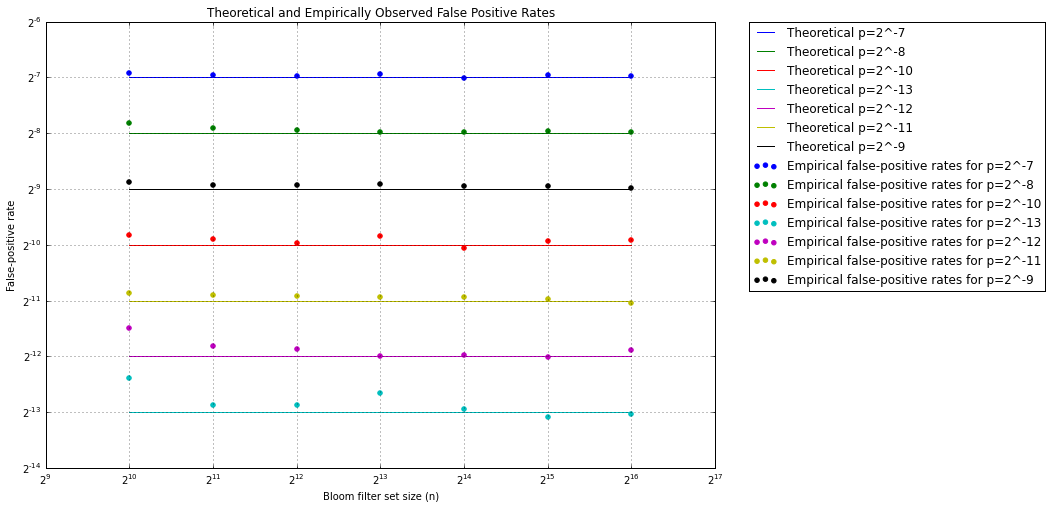

In [4]:
results_dict = pickle.load(open(FP_RATES_OUTPUT_FILE))
graph_results(results_dict)

In [5]:
def graph_cbf_results(results):
    x_values = sorted(results.keys())
    # Graph theoretical and empirical false positive rates
    plt.figure(figsize=(12, 8), dpi=400)
    plt.semilogy(x_values, [results[x]['theoretical'] for x in x_values],
            marker='o', label='Theoretical false positive rate')
    plt.semilogy(x_values, [results[x]['empirical'] for x in x_values],
            marker='o', label='Empirical false positive rate')
    
    plt.grid(True)
    plt.title("Theoretical and Empirically Observed False Positive Rates "
              "For Different Size Multipliers")
    plt.xlabel("Uncompressed size multiplier\nHigher means more memory used")
    plt.ylabel("False-positive rate")
    plt.legend()
    plt.show()
    
    # Graph insert times
    fig, ax1 = plt.subplots()
    fig.dpi = 400
    fig.set_size_inches(12, 8)

    ax1.plot(x_values, [results[x]['insert time'] for x in x_values],
            marker='o', label='Insert time')
    ax1.grid(True)
    ax1.set_title("Total Insert Times For Different Size Multipliers "
                  "(Inserting 10 ** 6 items)")
    ax1.set_xlabel("Uncompressed size multiplier\nHigher means more memory used")
    ax1.set_ylabel("Total insert time (seconds)")
    ax1.legend()
    
    sample_size = results[1]['insert size']
    ax2 = ax1.twinx()
    ax2.set_ylabel('k (number of hash functions used)')
    ax2.plot(x_values, [results[x]['k'] for x in x_values],
            marker='o', color='green', label='k values')
    ax2.legend(bbox_to_anchor=(0.97, 0.93), loc=1, borderaxespad=0.)
    plt.show()
    
    # Graph pre and post-compression file sizes
    plt.figure(figsize=(12, 8), dpi=400)
    plt.plot(x_values, [results[x]['file size pre']/1024.0 for x in x_values],
            marker='o', label='File size before compression')
    plt.plot(x_values, [results[x]['file size post']/1024.0 for x in x_values],
            marker='o', label='File sized compressed using arithmetic coding')
    
    plt.grid(True)
    plt.title("Pre- and Post-Compression File Sizes For Different Size Multipliers")
    plt.xlabel("Uncompressed size multiplier\nHigher means more memory used")
    plt.ylabel("File size (kilobytes)")
    plt.legend()
    plt.show()        


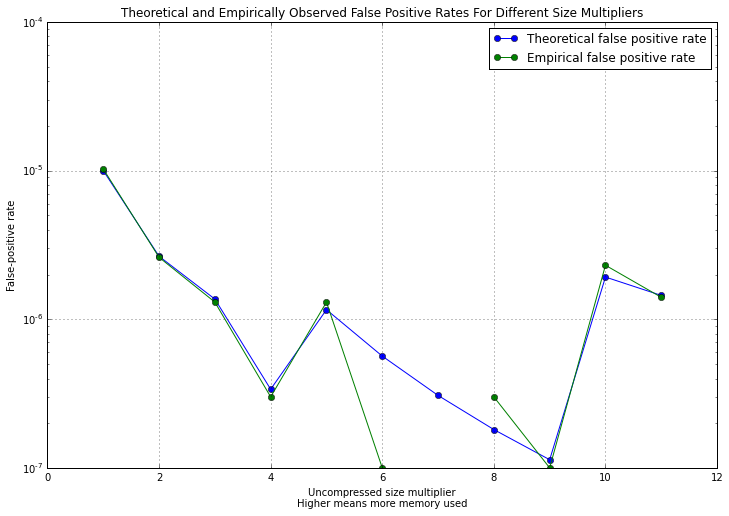

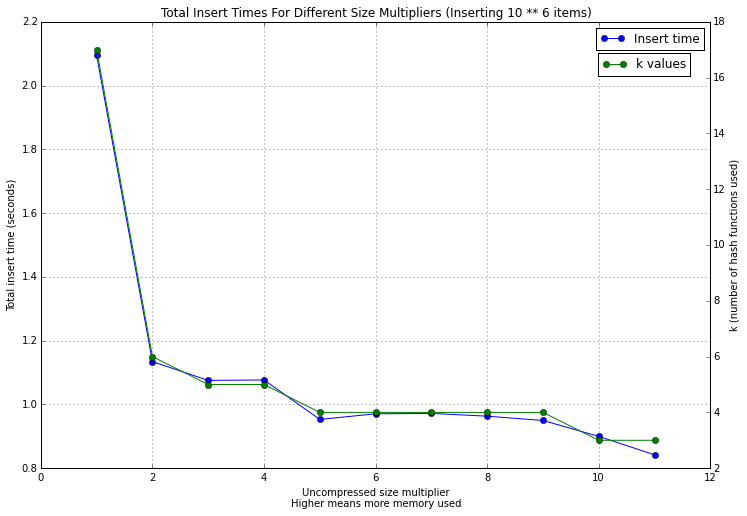

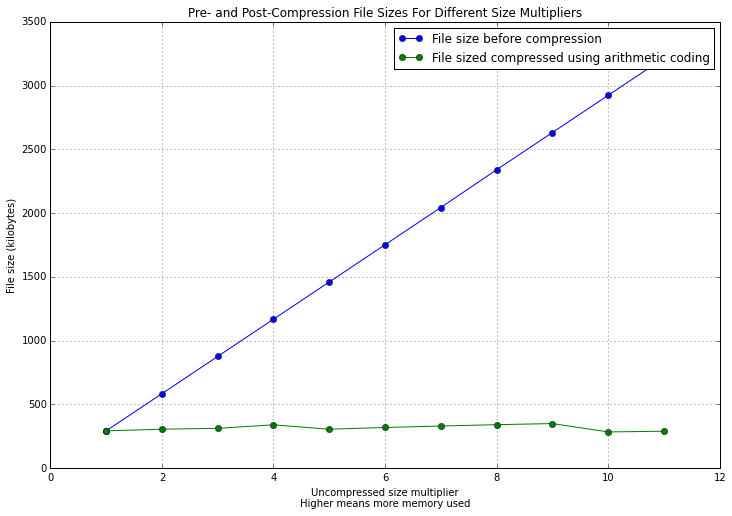

In [8]:
compressed_results_dict = pickle.load(open(COMPRESSED_RESULTS_FILE))
graph_cbf_results(compressed_results_dict)

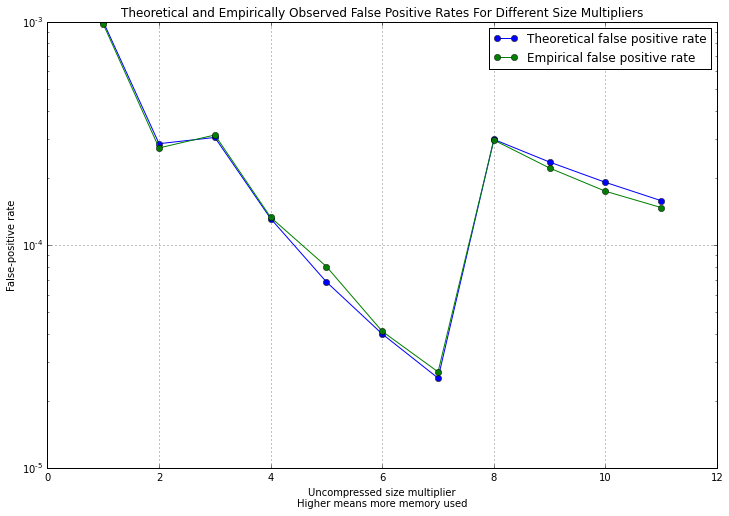

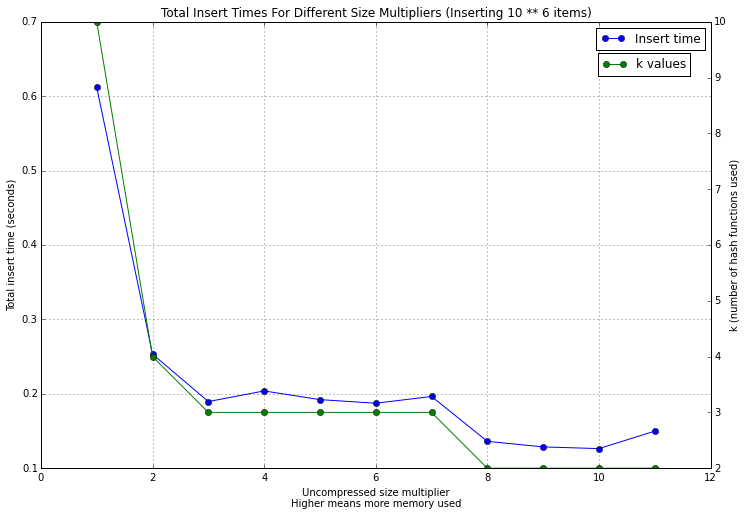

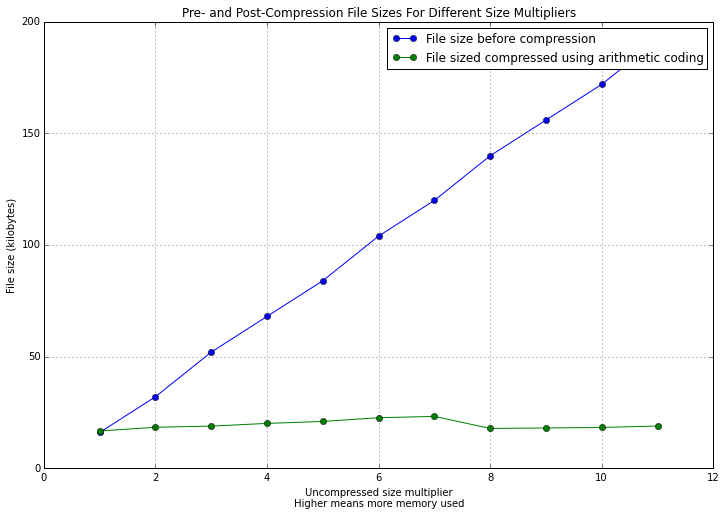

In [7]:
smaller_compressed_results_dict = pickle.load(open(COMPRESSED_RESULTS_SMALLER_FILE))
graph_cbf_results(smaller_compressed_results_dict)
